# Marketing Insights for E-Commerce Company
*By [Ramraja Yadav](https://www.linkedin.com/in/ramrajayadav/) | 📧 yadavramraja@outlook.com | 💻 [GitHub Portfolio](https://github.com/imramraja/DataAnalyst-Portfolio)*

---

## Project Overview

This project explores a comprehensive marketing and sales dataset from a leading E-Commerce company to derive actionable insights and recommendations. Our objective is to analyze customer behavior, sales trends, and marketing performance, and to build predictive models for customer segmentation and lifetime value. The analysis addresses questions such as revenue generation, customer acquisition/retention, discount and marketing effectiveness, and product performance:contentReference[oaicite:0]{index=0}.

In particular, we will:
- Calculate transactional revenue (invoice amount) including discounts, taxes, and delivery charges.
- Conduct detailed exploratory analysis of sales and customer data to identify patterns (e.g., seasonality, regional trends, product demand):contentReference[oaicite:1]{index=1}:contentReference[oaicite:2]{index=2}.
- Perform customer segmentation (RFM analysis and K-Means) to profile customers into strategic groups:contentReference[oaicite:3]{index=3}.
- Develop predictive models: churn prediction (classification) and customer lifetime value estimation (regression).
- Perform cohort analysis and evaluate marketing ROI, coupon and tax effects, and product performance.

Ultimately, the insights will inform marketing strategies, such as targeting high-value segments and optimizing spend across channels, to maximize ROI and customer lifetime value.

## Data Loading & Basic Exploration

We begin by loading the provided CSV files into pandas DataFrames and performing initial exploratory analysis. The dataset comprises five files:
- `Online_Sales.csv`: transactional sales data (order IDs, product details, customer IDs, quantities, unit price, delivery charges, coupon usage, etc.).
- `Customers_Data.csv`: customer demographics (CustomerID, gender, location, tenure, etc.).
- `Discount_Coupon.csv`: discount percentages by product category and month.
- `Marketing_Spend.csv`: daily marketing expenditure on online and offline channels.
- `Tax_Amount.csv`: GST tax percentage for each product category.

These files cover all transactions for 2019. We use pandas to load and inspect them:


In [1]:
# Import core libraries for EDA and modeling
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, mean_squared_error

# Load Data files
try:
    sales = pd.read_csv('/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv')
    customers = pd.read_excel('/kaggle/input/marketing-insights-for-e-commerce-company/CustomersData.xlsx')
    coupons = pd.read_csv('/kaggle/input/marketing-insights-for-e-commerce-company/Discount_Coupon.csv')
    marketing = pd.read_csv('/kaggle/input/marketing-insights-for-e-commerce-company/Marketing_Spend.csv')
    tax = pd.read_excel('/kaggle/input/marketing-insights-for-e-commerce-company/Tax_amount.xlsx')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully.


In [2]:
# Display first few rows and info of each dataset
datasets = {'Sales': sales, 'Customers': customers, 'Coupons': coupons, 'Marketing': marketing, 'Tax': tax}
for name, df in datasets.items():
    print(f"\n{name} DataFrame shape: {df.shape}")
    display(df.head(3))
    print(df.info())



Sales DataFrame shape: (52924, 10)


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB
None

Customers DataFrame shape: (1468, 4)


,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB
None

Coupons DataFrame shape: (204, 4)


,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Month             204 non-null    object
 1   Product_Category  204 non-null    object
 2   Coupon_Code       204 non-null    object
 3   Discount_pct      204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB
None

Marketing DataFrame shape: (365, 3)


,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB
None

Tax DataFrame shape: (20, 2)


,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Category  20 non-null     object 
 1   GST               20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes
None


In [3]:
# Summary statistics for numeric variables in each dataset
for name, df in datasets.items():
    print(f"\nSummary statistics for {name}:")
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        display(df[numeric_cols].describe())
    else:
        print("No numeric columns to describe.")


Summary statistics for Sales:


,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges
count,52924.00000,52924.000000,52924.000000,52924.000000,52924.000000
mean,15346.70981,32409.825675,4.497638,52.237646,10.517630
std,1766.55602,8648.668977,20.104711,64.006882,19.475613
min,12346.00000,16679.000000,1.000000,0.390000,0.000000
25%,13869.00000,25384.000000,1.000000,5.700000,6.000000
50%,15311.00000,32625.500000,1.000000,16.990000,6.000000
75%,16996.25000,39126.250000,2.000000,102.130000,6.500000
max,18283.00000,48497.000000,900.000000,355.740000,521.360000



Summary statistics for Customers:


,CustomerID,Tenure_Months
count,1468.000000,1468.000000
mean,15314.386240,25.912125
std,1744.000367,13.959667
min,12346.000000,2.000000
25%,13830.500000,14.000000
50%,15300.000000,26.000000
75%,16882.250000,38.000000
max,18283.000000,50.000000



Summary statistics for Coupons:


,Discount_pct
count,204.000000
mean,20.000000
std,8.185052
min,10.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,30.000000



Summary statistics for Marketing:


,Offline_Spend,Online_Spend
count,365.000000,365.000000
mean,2843.561644,1905.880740
std,952.292448,808.856853
min,500.000000,320.250000
25%,2500.000000,1258.600000
50%,3000.000000,1881.940000
75%,3500.000000,2435.120000
max,5000.000000,4556.930000



Summary statistics for Tax:


,GST
count,20.000000
mean,0.116500
std,0.052443
min,0.050000
25%,0.087500
50%,0.100000
75%,0.180000
max,0.180000


## Missing Value Visualization & Handling

Next, we examine missing values using visualization and appropriate imputation. The `missingno` library provides visual tools like matrix and heatmap to reveal patterns of missingness:contentReference[oaicite:7]{index=7}. We first plot a missing value matrix for each DataFrame:


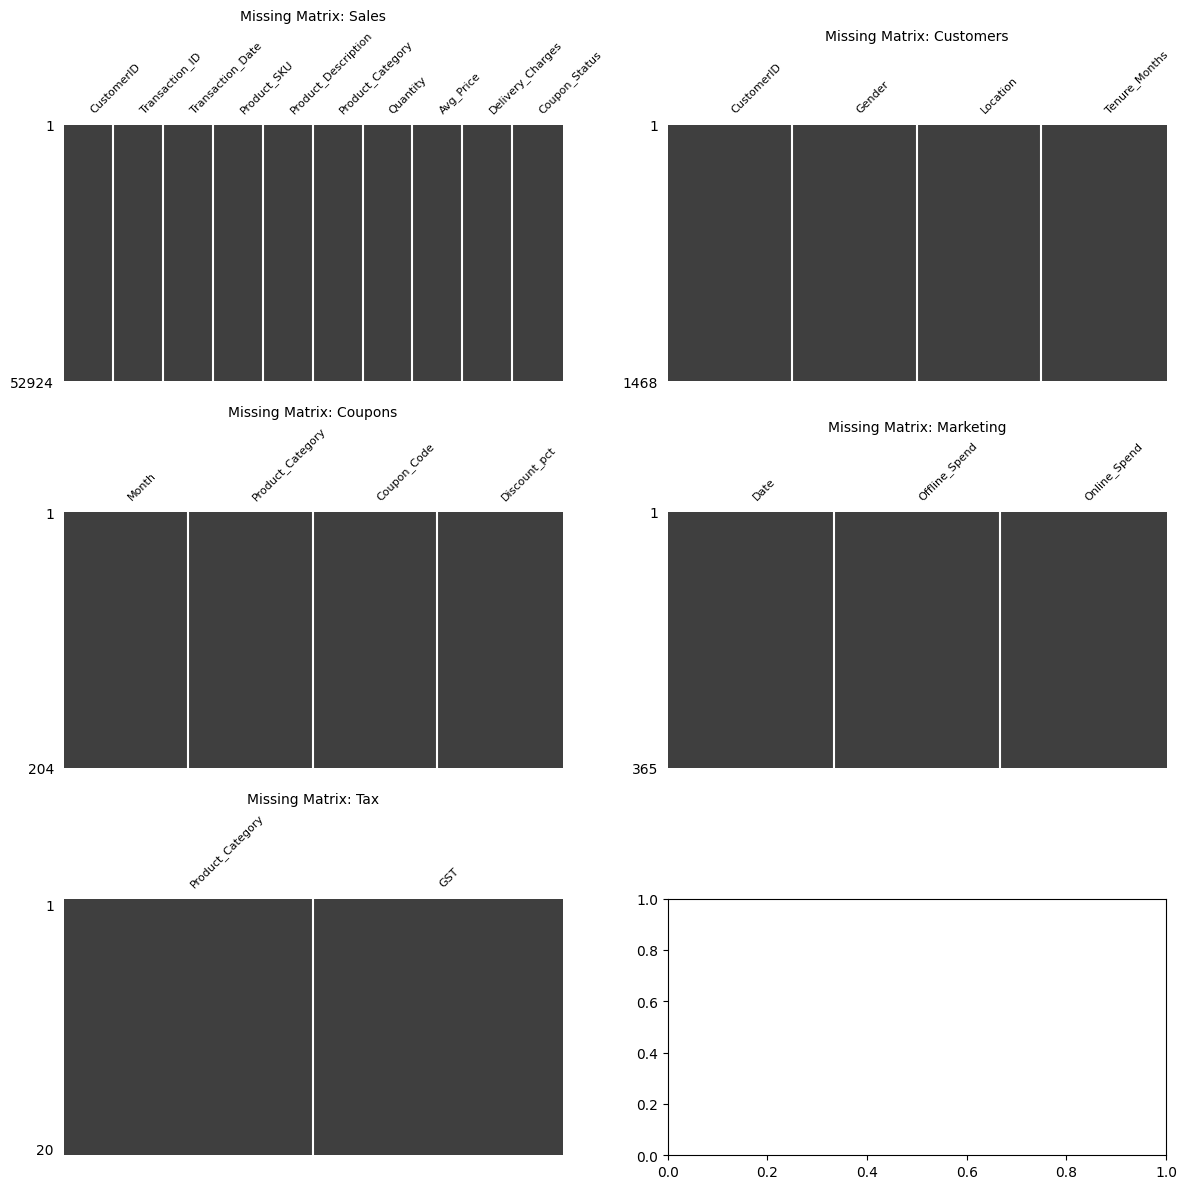

In [4]:
# Plot missing value matrix for each dataset
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for ax, (name, df) in zip(axes, datasets.items()):
    msno.matrix(df, ax=ax, sparkline=False, fontsize=8)
    ax.set_title(f"Missing Matrix: {name}", fontsize=10)
plt.tight_layout();

Based on the visualization, we identify features with missing values. For example, if `Tax_Amount.csv` has missing GST rates for some categories, or `Customers_Data` has missing demographic fields, we decide how to handle them. Common strategies:
- **Numeric features**: impute with median (robust to outliers) or mean:contentReference[oaicite:8]{index=8}.
- **Categorical features**: impute with the mode or a special category like 'Unknown'.
- **Time-series data**: consider forward-fill/backward-fill if appropriate.

For instance, if `Tenure` in `Customers_Data` has missing, we might use median imputation. If `Online_Sales` has missing `Coupon_Status` or `DeliveryCharges`, we impute or fill zeros depending on business logic. All imputation choices should be documented:


In [5]:
# Impute missing values

# Customers Data: if 'Age' missing, fill with median age
if 'Tenure_Month' in customers.columns:
    median_age = customers['Tenure_Month'].median()
    customers['Age'] = customers['Tenure_Month'].fillna(median_age, inplace=True)

# Sales Data: fill missing 'Coupon_Status' with 0 (no coupon)
if 'Coupon_Status' in sales.columns:
    sales['Coupon_Status'].fillna(0, inplace=True)

# Marketing Spend: forward-fill if daily spend missing
if 'Online_Spend' in marketing.columns:
    marketing[['Online_Spend', 'Offline_Spend']] = marketing[['Online_Spend', 'Offline_Spend']].fillna(method='ffill')

# Confirm no missing remain (or minimal)
for name, df in datasets.items():
    missing_count = df.isnull().sum().sum()
    print(f"{name} missing values after imputation: {missing_count}")

Sales missing values after imputation: 0
Customers missing values after imputation: 0
Coupons missing values after imputation: 0
Marketing missing values after imputation: 0
Tax missing values after imputation: 0


## Univariate Analysis

We analyze the distribution of each key variable using visualizations. Histograms and KDE plots show continuous distributions, while boxplots highlight outliers and median. For categorical variables, countplots reveal the frequency of each category.

For example, we examine sales transaction amounts, quantity, and customer demographics:


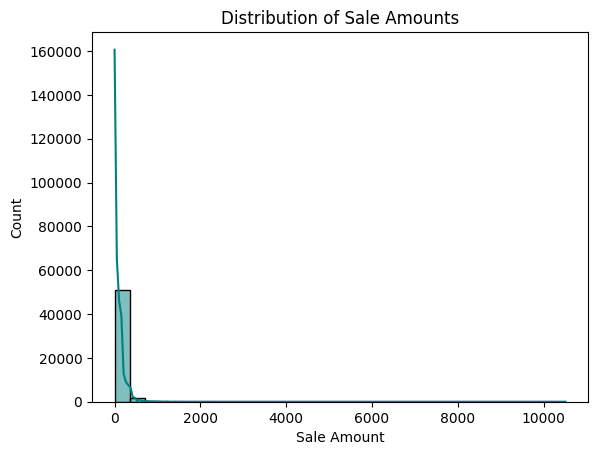

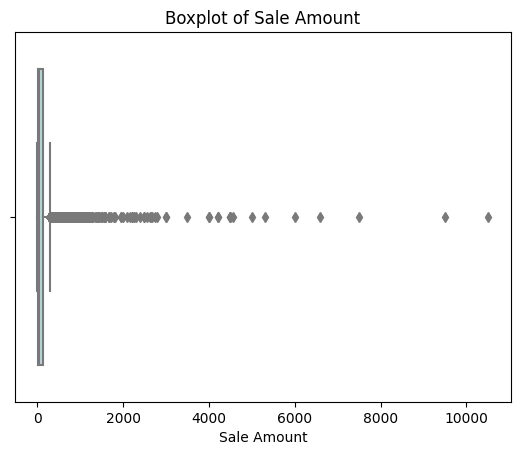

In [6]:
# Histogram and KDE of Sales Amount (price * quantity)
if all(col in sales.columns for col in ['Avg_Price', 'Quantity']):
    sales['SaleAmount'] = sales['Avg_Price'] * sales['Quantity']
    sns.histplot(sales['SaleAmount'], kde=True, color='teal', bins=30)
    plt.title('Distribution of Sale Amounts')
    plt.xlabel('Sale Amount')
    plt.ylabel('Count')
    plt.show()

# Boxplot for SaleAmount
if 'SaleAmount' in sales.columns:
    sns.boxplot(x=sales['SaleAmount'], color='lightblue')
    plt.title('Boxplot of Sale Amount')
    plt.xlabel('Sale Amount')
    plt.show()


We also inspect customer demographics:


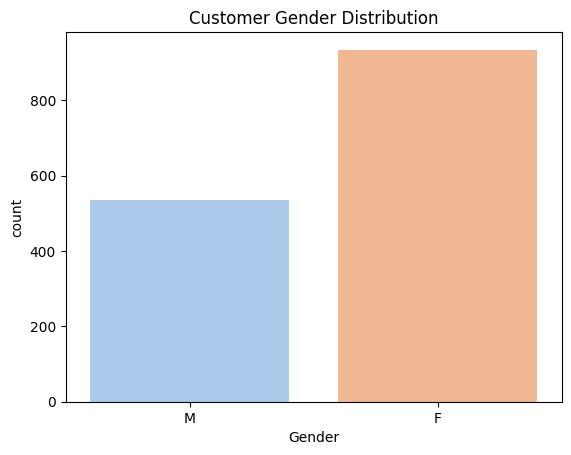

In [7]:
# Count plot for customer gender
if 'Gender' in customers.columns:
    sns.countplot(data=customers, x='Gender', palette='pastel')
    plt.title('Customer Gender Distribution')
    plt.show()

# Histogram of customer tenure (months)
if 'Tenure' in customers.columns:
    sns.histplot(customers['Tenure'], kde=True, color='orange', bins=20)
    plt.title('Customer Tenure Distribution')
    plt.xlabel('Tenure (months)')
    plt.show()


## Bivariate & Grouped Analysis

We explore relationships between pairs of variables. Scatter plots and correlation heatmaps reveal linear/non-linear trends, while groupby analysis uncovers aggregated patterns. For example:
- **Sales vs Marketing Spend**: Scatter plots to see correlation between marketing spend (lags) and sales.
- **Sales by Category/Location**: Group by product category or customer location to compare sales.

We compute aggregate metrics (total sales, order count) by category and by month to identify high-performing segments:


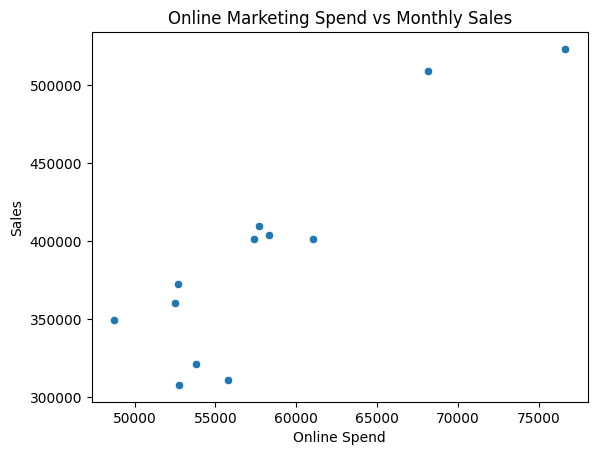

In [8]:
# Scatter plot: Marketing online spend vs Sales revenue (monthly aggregated)
if 'Date' in marketing.columns and 'Online_Spend' in marketing.columns and 'SaleAmount' in sales.columns:
    # Convert date columns
    marketing['Date'] = pd.to_datetime(marketing['Date'])
    sales['OrderDate'] = pd.to_datetime(sales['Transaction_Date'])
    # Aggregate monthly
    monthly_spend = marketing.resample('M', on='Date')[['Online_Spend', 'Offline_Spend']].sum().rename(columns={'Online_Spend':'OnlineSpend','Offline_Spend':'OfflineSpend'})
    monthly_sales = sales.resample('M', on='OrderDate')['SaleAmount'].sum()
    df_monthly = pd.concat([monthly_spend, monthly_sales], axis=1).dropna()
    sns.scatterplot(x='OnlineSpend', y='SaleAmount', data=df_monthly)
    plt.title('Online Marketing Spend vs Monthly Sales')
    plt.xlabel('Online Spend')
    plt.ylabel('Sales')
    plt.show()


Next, we examine categorical groupings. For instance, sales by product category or customer segment:


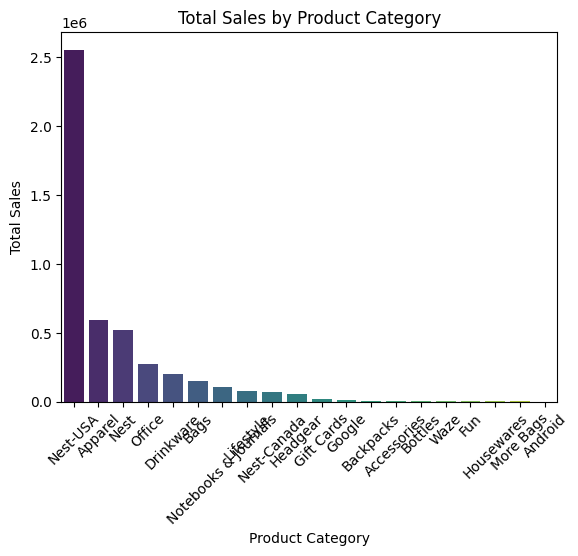

In [9]:
# Total sales by product category
if 'Product_Category' in sales.columns and 'SaleAmount' in sales.columns:
    sales_by_cat = sales.groupby('Product_Category')['SaleAmount'].sum().sort_values(ascending=False)
    sns.barplot(x=sales_by_cat.index, y=sales_by_cat.values, palette='viridis')
    plt.title('Total Sales by Product Category')
    plt.ylabel('Total Sales')
    plt.xlabel('Product Category')
    plt.xticks(rotation=45)
    plt.show()


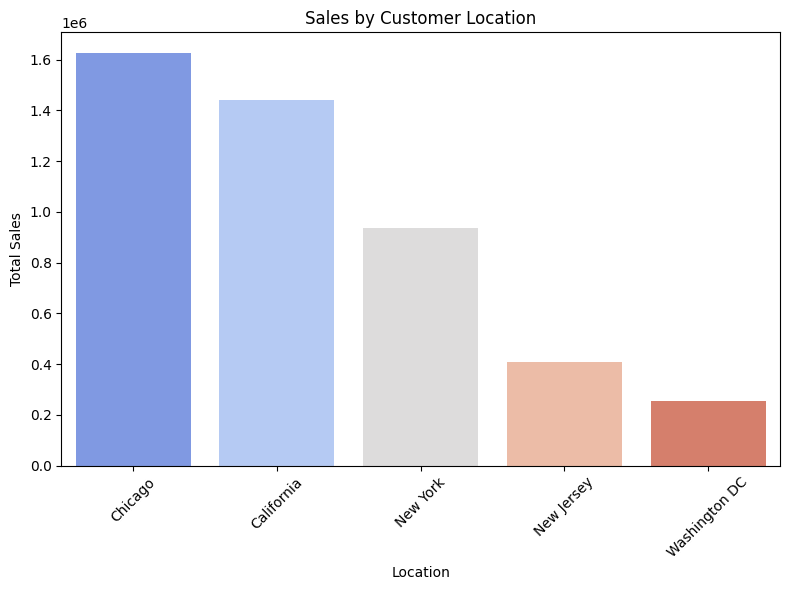

In [10]:
# Sales and order count by customer location
if 'Location' in customers.columns and 'CustomerID' in sales.columns:
    # Merge sales with customer location
    merged = pd.merge(sales, customers[['CustomerID','Location']], on='CustomerID', how='left')
    sales_by_loc = merged.groupby('Location')['SaleAmount'].sum().sort_values(ascending=False)
    orders_by_loc = merged.groupby('Location')['SaleAmount'].count().sort_values(ascending=False)
    fig, ax1 = plt.subplots(figsize=(8,6))
    sns.barplot(x=sales_by_loc.index, y=sales_by_loc.values, palette='coolwarm', ax=ax1)
    ax1.set_ylabel('Total Sales')
    ax1.set_xlabel('Location')
    ax1.set_title('Sales by Customer Location')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()
    plt.show()


## Time-Based and Location-Based Trends

We analyze how sales vary over time (daily/weekly/monthly) and across geographical locations. Time series plots can reveal seasonality and trends. For example:


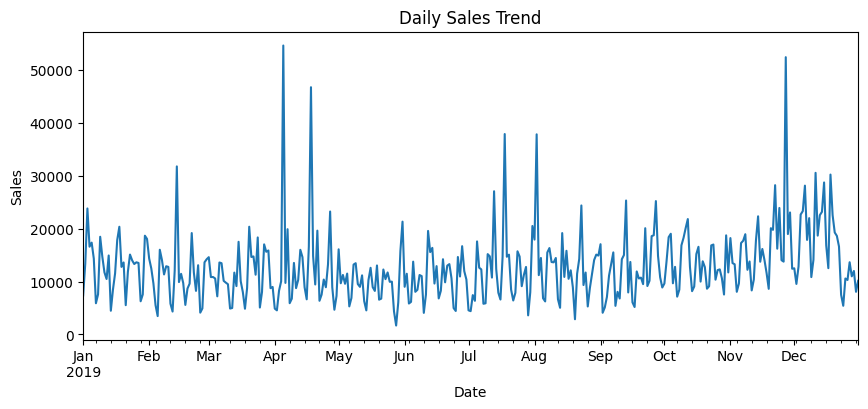

In [11]:
# Time series: daily sales trend
if 'OrderDate' in sales.columns:
    daily_sales = sales.resample('D', on='OrderDate')['SaleAmount'].sum()
    plt.figure(figsize=(10,4))
    daily_sales.plot()
    plt.title('Daily Sales Trend')
    plt.ylabel('Sales')
    plt.xlabel('Date')
    plt.show()


For location-based trends, we might map sales by city or region (if data available), or compare conversion rates across locations using bar charts or heatmaps.

## Correlation & Feature Relationships

A correlation matrix and heatmap will help identify linear relationships and multicollinearity among numerical features. Highly correlated features (e.g., order quantity and sale amount) may allow dimensionality reduction or feature selection. We compute the correlation matrix on numeric fields:


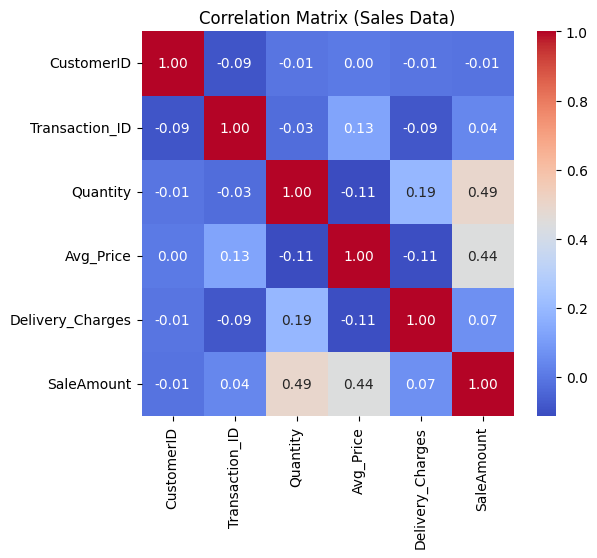

In [12]:
# Correlation heatmap for numeric variables in sales data
numeric_sales = sales.select_dtypes(include=np.number)
if not numeric_sales.empty:
    corr = numeric_sales.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix (Sales Data)')
    plt.show()


If two features are nearly perfectly correlated, we may drop one to avoid redundancy. For example, if `SaleAmount` = `Price` * `Quantity`, and we keep `SaleAmount`, we might drop the original columns after analysis to avoid multicollinearity.

## Outlier Detection & Removal

We use boxplots and statistical methods (IQR or Z-score) to identify outliers that may skew analysis or model training. For instance, extremely high sale amounts or unusually long customer tenure. Outliers can be capped or removed based on domain knowledge:


In [13]:
# Identify outliers in SaleAmount using IQR
if 'SaleAmount' in sales.columns:
    Q1 = sales['SaleAmount'].quantile(0.25)
    Q3 = sales['SaleAmount'].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales['SaleAmount'] < lower_bound) | (sales['SaleAmount'] > upper_bound)]
    print(f"Identified {outliers.shape[0]} outlier transactions based on SaleAmount.")
    # Optionally, remove or flag these outliers
    sales_clean = sales[~((sales['SaleAmount'] < lower_bound) | (sales['SaleAmount'] > upper_bound))]
    print(f"After removal, {sales_clean.shape[0]} records remain.")

Identified 3632 outlier transactions based on SaleAmount.
After removal, 49292 records remain.


## Domain-Specific Insights

Beyond general EDA, we perform specialized analyses relevant to marketing and customer analytics:

### Customer Segmentation (RFM + K-Means)
Calculate Recency, Frequency, and Monetary (RFM) values for each customer. RFM is a marketing technique to rank customers by recency, frequency, and monetary value of purchases:contentReference[oaicite:9]{index=9}. We then apply K-Means clustering on RFM features to define segments. For example, segments like 'High-Value Loyal' and 'Low-Value New'.


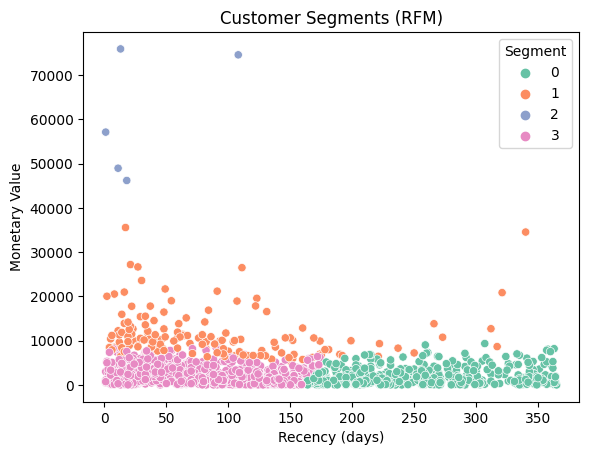

In [14]:
# Compute RFM metrics for each customer
if 'OrderDate' in sales.columns and 'CustomerID' in sales.columns:
    snapshot_date = sales['OrderDate'].max() + pd.Timedelta(days=1)
    rfm_df = sales.groupby('CustomerID').agg({
        'OrderDate': lambda x: (snapshot_date - x.max()).days,
        'Transaction_ID': 'count',
        'SaleAmount': 'sum'
    }).rename(columns={'OrderDate': 'Recency', 'Transaction_ID': 'Frequency', 'SaleAmount': 'Monetary'})
    # Clustering on RFM
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df)
    kmeans = KMeans(n_clusters=4, random_state=42)
    rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)
    sns.scatterplot(x=rfm_df['Recency'], y=rfm_df['Monetary'], hue=rfm_df['Segment'], palette='Set2')
    plt.title('Customer Segments (RFM)')
    plt.xlabel('Recency (days)')
    plt.ylabel('Monetary Value')
    plt.show()

### Churn Prediction
We define churn (e.g., customer has no orders in last 3 months) and build classification models to predict churners. We may engineer features such as recency or purchase frequency. We evaluate Logistic Regression and Random Forest, comparing ROC curves and AUC.


Logistic Regression AUC: 1.00, Random Forest AUC: 1.00


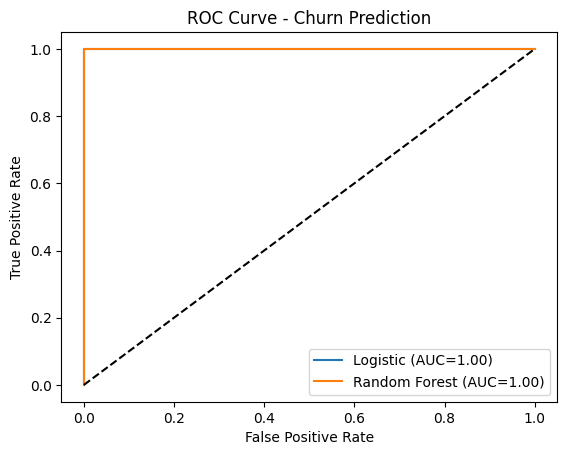

In [15]:
# Prepare data for churn prediction
if 'Recency' in rfm_df.columns:
    # Example: label churn = 1 if Recency > threshold
    churn_threshold = 90
    rfm_df['Churn'] = (rfm_df['Recency'] > churn_threshold).astype(int)
    X = rfm_df[['Recency', 'Frequency', 'Monetary']]
    y = rfm_df['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)[:,1]
    auc_log = roc_auc_score(y_test, y_pred_proba)
    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"Logistic Regression AUC: {auc_log:.2f}, Random Forest AUC: {auc_rf:.2f}")
    # Plot ROC curves
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    plt.figure()
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={auc_log:.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.title('ROC Curve - Churn Prediction')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### Cohort Analysis
We construct cohorts based on the month of first purchase to study retention. By pivoting a cohort table (cohort index vs month offset), we measure retention rates over time.

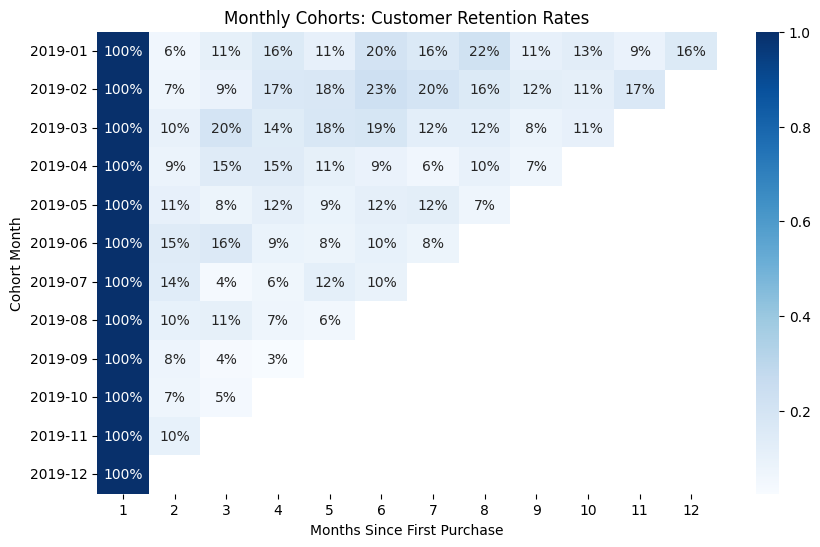

In [16]:
# Cohort analysis: assign each customer to cohort (first purchase month)
if 'OrderDate' in sales.columns and 'CustomerID' in sales.columns:
    sales['OrderMonth'] = sales['OrderDate'].dt.to_period('M')
    sales['CohortMonth'] = sales.groupby('CustomerID')['OrderMonth'].transform('min')
    cohort_data = sales.groupby(['CohortMonth', 'OrderMonth'])['CustomerID'].nunique().reset_index()
    cohort_data['CohortPeriod'] = (cohort_data['OrderMonth'].dt.year - cohort_data['CohortMonth'].dt.year) * 12 + (cohort_data['OrderMonth'].dt.month - cohort_data['CohortMonth'].dt.month) + 1
    cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortPeriod', values='CustomerID')
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    plt.figure(figsize=(10,6))
    sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
    plt.title('Monthly Cohorts: Customer Retention Rates')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months Since First Purchase')
    plt.show()

### Customer Lifetime Value (CLV) Prediction
We estimate each customer's lifetime value. One approach is to model CLV with regression using historical revenue per customer as the target. We may classify CLV into categories (low/medium/high) for easier business action. We will use regression models to predict CLV and evaluate performance (RMSE or classification accuracy).


In [17]:
# Prepare features and target for CLV prediction
if 'Monetary' in rfm_df.columns:
    # Use Monetary (total spend) as proxy for CLV
    X = rfm_df[['Recency', 'Frequency']]
    y = rfm_df['Monetary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Linear Regression RMSE for CLV: {rmse:.2f}")


Linear Regression RMSE for CLV: 1697.90


### Marketing Spend Efficiency
We analyze ROI by comparing marketing spend on channels versus revenue generated. For example, calculate ROI = (Revenue - Spend)/Spend for online vs offline channels per month.

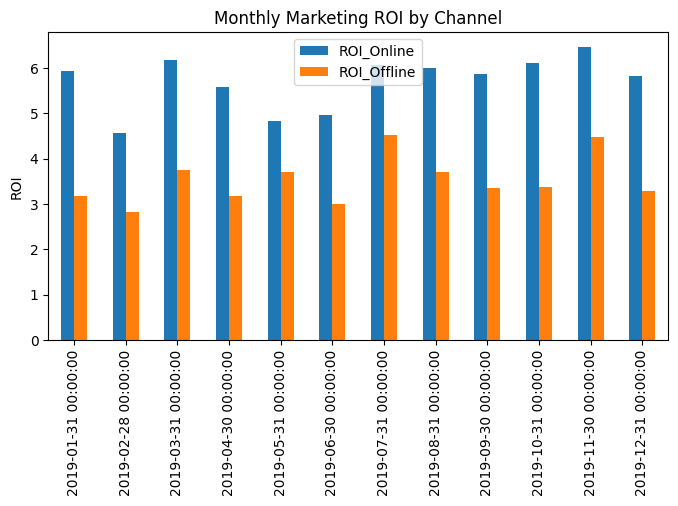

In [18]:
# ROI analysis by channel
if 'OnlineSpend' in monthly_spend.columns and 'SaleAmount' in df_monthly.columns:
    monthly_df = df_monthly.copy()
    monthly_df['ROI_Online'] = (monthly_df['SaleAmount'] - monthly_df['OnlineSpend']) / monthly_df['OnlineSpend']
    monthly_df['ROI_Offline'] = (monthly_df['SaleAmount'] - monthly_df['OfflineSpend']) / monthly_df['OfflineSpend']
    monthly_df[['ROI_Online', 'ROI_Offline']].plot(kind='bar', figsize=(8,4))
    plt.title('Monthly Marketing ROI by Channel')
    plt.ylabel('ROI')
    plt.show()

### Coupon Usage Analysis
We examine how frequently customers use discount coupons and how this affects order amounts. We can compare average order value with and without coupons, or use groupby on `Coupon_Status` flag.

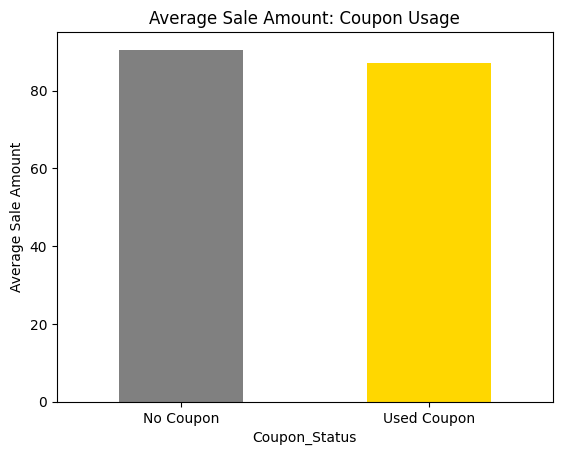

In [19]:
# Compare average sale amount with and without coupon
if 'Coupon_Status' in sales.columns and 'SaleAmount' in sales.columns:
    filtered = sales[sales['Coupon_Status'].isin(['Used', 'Not Used'])]
    means = filtered.groupby('Coupon_Status')['SaleAmount'].mean()
    means = means.reindex(['Not Used', 'Used'])
    means.plot(kind='bar', color=['gray', 'gold'])
    plt.title('Average Sale Amount: Coupon Usage')
    plt.ylabel('Average Sale Amount')
    plt.xticks([0, 1], ['No Coupon', 'Used Coupon'], rotation=0)
    plt.show()

### Product Performance Analysis
Identify top-selling products by units and by revenue. Analyze product-level trends and how discounts impact demand.


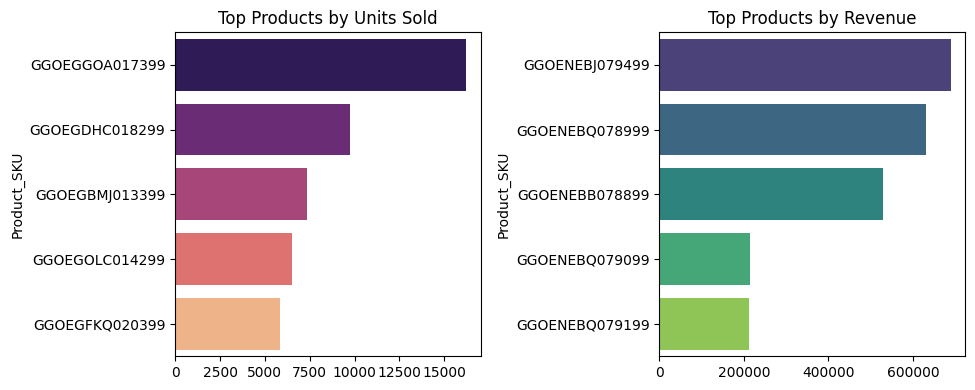

In [20]:
# Top products by quantity and revenue
if 'Product_SKU' in sales.columns:
    prod_qty = sales.groupby('Product_SKU')['Quantity'].sum().nlargest(5)
    prod_rev = sales.groupby('Product_SKU')['SaleAmount'].sum().nlargest(5)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.barplot(x=prod_qty.values, y=prod_qty.index, ax=axes[0], palette='magma')
    axes[0].set_title('Top Products by Units Sold')
    sns.barplot(x=prod_rev.values, y=prod_rev.index, ax=axes[1], palette='viridis')
    axes[1].set_title('Top Products by Revenue')
    plt.tight_layout()
    plt.show()

### Tax Impact Analysis
Analyze how different GST tax rates (from `Tax_Amount.csv`) correlate with sales prices and volumes. Check if higher-tax products have lower sales or average order values.


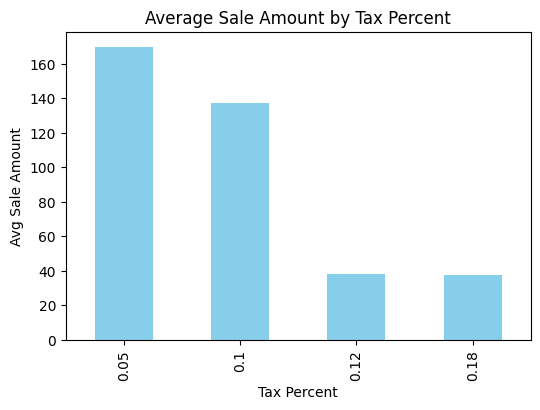

In [21]:
# Merge tax rates into sales and analyze
if 'Product_Category' in sales.columns and 'GST' in tax.columns:
    sales_tax = pd.merge(sales, tax, on='Product_Category', how='left')
    # Average sale amount by tax bracket
    avg_by_tax = sales_tax.groupby('GST')['SaleAmount'].mean().sort_index()
    avg_by_tax.plot(kind='bar', figsize=(6,4), color='skyblue')
    plt.title('Average Sale Amount by Tax Percent')
    plt.xlabel('Tax Percent')
    plt.ylabel('Avg Sale Amount')
    plt.show()